In [ ]:
import pandas as pd
import glob

csv_files = glob.glob("../results/*.csv")

df_list = []

for file in csv_files:
    region_name = file.split("\\")[-1].split(".csv")[0]
    
    df = pd.read_csv(file)
    df["Region"] = region_name
    df_list.append(df)

all_df = pd.concat(df_list, ignore_index=True)

C:\Users\rahul\AppData\Local\Temp\ipykernel_9984\4053205636.py:22: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\rahul\AppData\Local\Temp\ipykernel_9984\4053205636.py:22: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\rahul\AppData\Local\Temp\ipykernel_9984\4053205636.py:23: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.savefig("../plots/independent/val_loss.png", dpi=300, bbox_inches="tight")
C:\Users\rahul\AppData\Local\Temp\ipykernel_9984\4053205636.py:23: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.savefig("../plots/independent/val_loss.png", dpi=300, bbox_inches="tight")


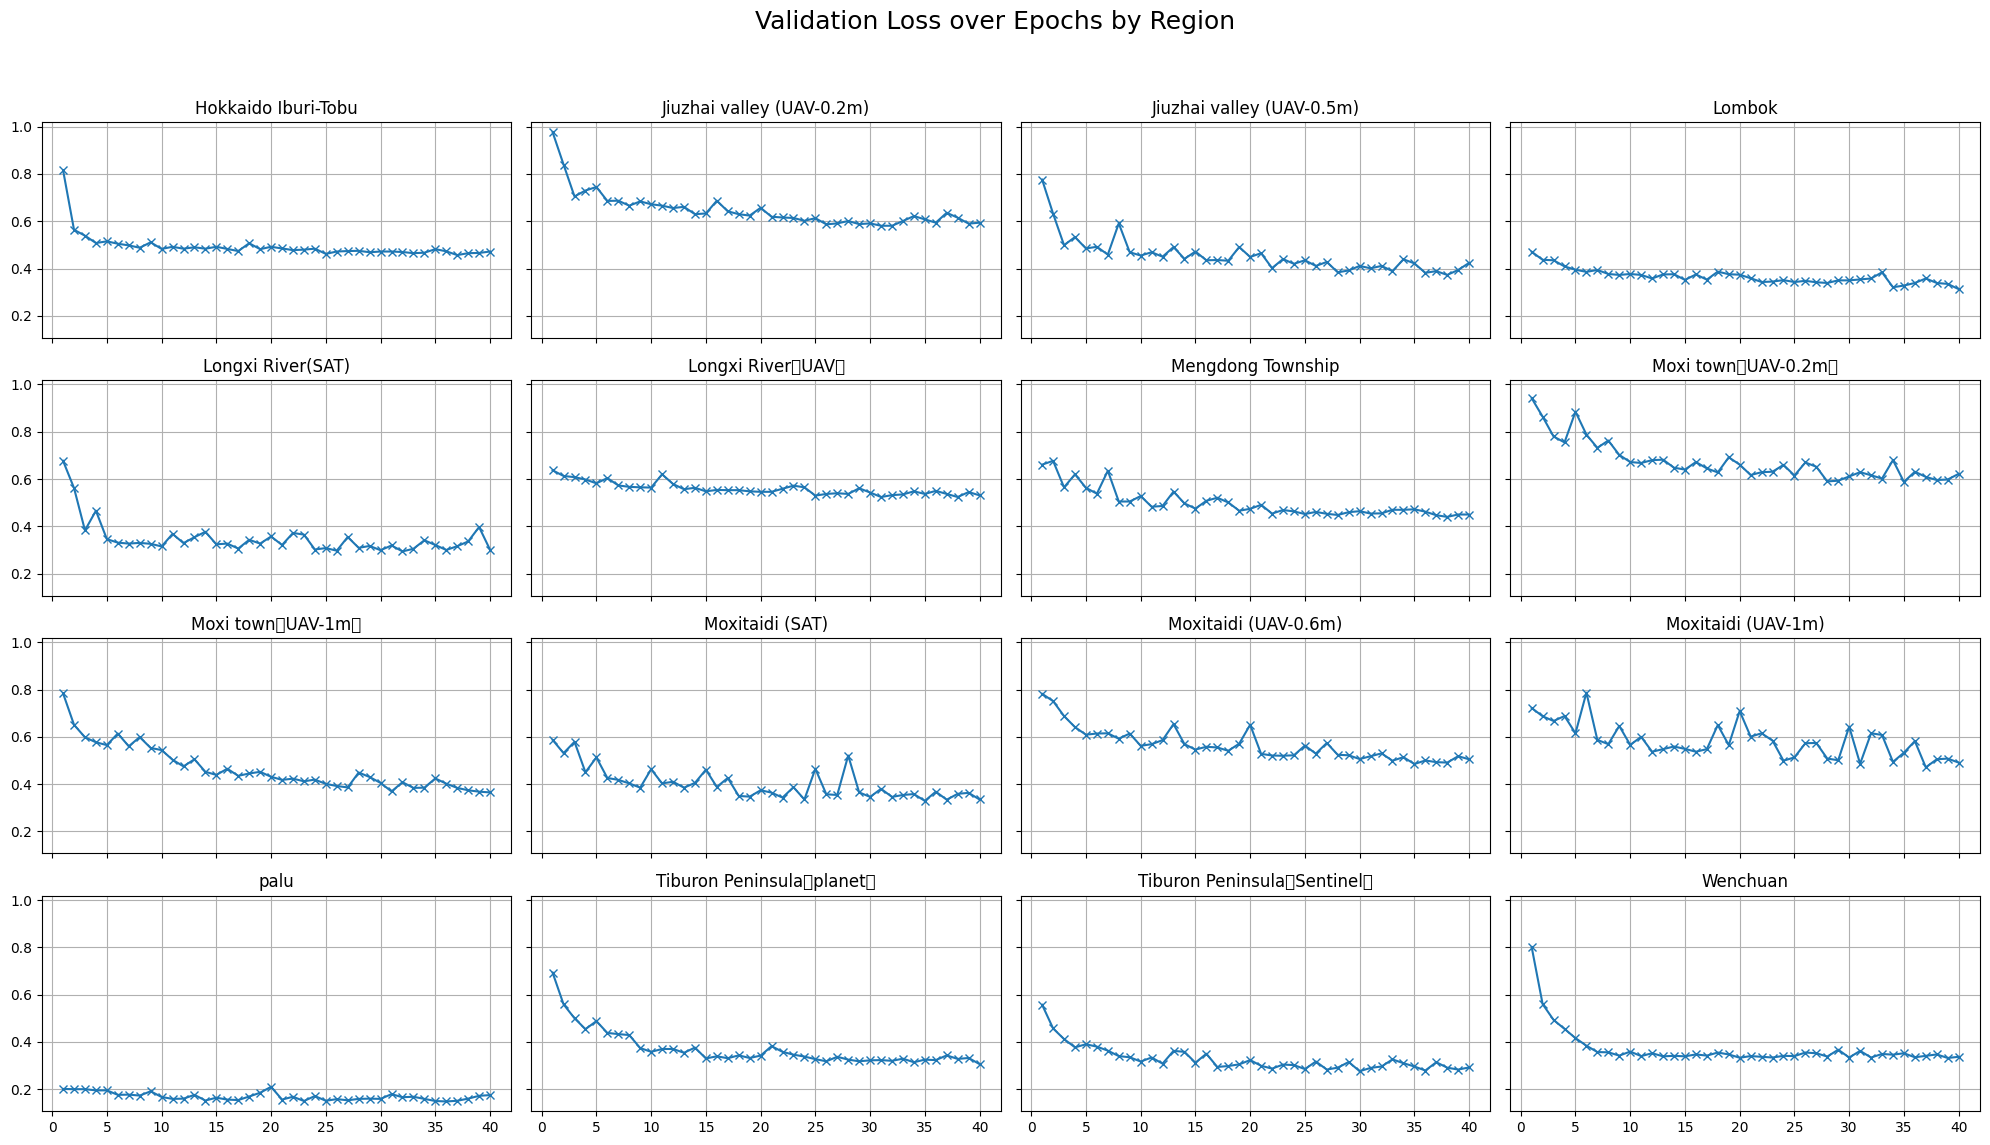

In [53]:
import matplotlib.pyplot as plt

regions = all_df["Region"].unique()
num_regions = len(regions)

cols = 4
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 12), sharex=True, sharey=True)

for idx, region in enumerate(regions):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    
    region_df = all_df[all_df["Region"] == region]
    ax.plot(region_df["epoch"], region_df["val_loss"], marker='x')
    ax.set_title(region)
    ax.grid(True)

fig.suptitle("Validation Loss over Epochs by Region", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../plots/independent/val_loss.png", dpi=300, bbox_inches="tight")
plt.show()